In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from models import KeckTelescope
from influenc_funcs import gaussian_influence_function
from prysm.interferogram import render_synthetic_surface
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.x.dm import DM

from san import SpeckleAreaNulling   
from SANKalman import SANKalman

In [49]:
def build_sim_env():
    """Build telescope, DM, and WFE identical to run_san.py."""
    Npup = 1024
    x, y, z = render_synthetic_surface(10, Npup, a=5e4, b=1/1000, c=3)
    wavefront_error = z / 2 
    keck = KeckTelescope(center_wavelength=1.65, bandwidth=1, starting_wfe=wavefront_error) 
    # --- detector parameters ------------
    keck.dark_current       = 5     # e⁻ /s
    keck.read_noise         = 1     # e⁻ /s
    keck.bias               = 10    # e⁻
    keck.bits               = 16
    keck.full_well_capacity = 2 ** keck.bits
    keck.conversion_gain    = 1     # e⁻ / DN
    keck.exposure_time      = 100  # s

    Nd = keck.dark_current * keck.exposure_time
    NR = keck.read_noise

    # --- DM ---------------
    nact, act_pitch, spa = 22, 3, 42       
    sampling_pitch = act_pitch / spa   
    
    x, y = make_xy_grid(keck.Npup, dx=sampling_pitch)
    r, _ = cart_to_polar(x, y)
    infl = gaussian_influence_function(r, act_pitch)
    dm = DM(infl, x.shape[0], nact, spa, rot=(0, 0, 0), shift=(0, 0))
    dm.act_pitch = act_pitch

    return keck, dm, wavefront_error, Nd, NR

/Users/andyzhou/Documents/Exoplanet Lab/cdi-san/SANKalman.py:115: RuntimeWarning: divide by zero encountered in divide
  d_p_I1p = (Dp - 2*Np)/Dp**2
/Users/andyzhou/Documents/Exoplanet Lab/cdi-san/SANKalman.py:116: RuntimeWarning: divide by zero encountered in divide
  d_p_I1m =-(Dp + 2*Np)/Dp**2
/Users/andyzhou/Documents/Exoplanet Lab/cdi-san/SANKalman.py:117: RuntimeWarning: divide by zero encountered in divide
  d_p_I0  = 4*Np/Dp**2
/Users/andyzhou/Documents/Exoplanet Lab/cdi-san/SANKalman.py:124: RuntimeWarning: invalid value encountered in divide
  d_q_I2p = (Dq - 2*Nq)/Dq**2
/Users/andyzhou/Documents/Exoplanet Lab/cdi-san/SANKalman.py:125: RuntimeWarning: invalid value encountered in divide
  d_q_I2m =-(Dq + 2*Nq)/Dq**2
/Users/andyzhou/Documents/Exoplanet Lab/cdi-san/SANKalman.py:126: RuntimeWarning: invalid value encountered in divide
  d_q_I0  = 4*Nq/Dq**2


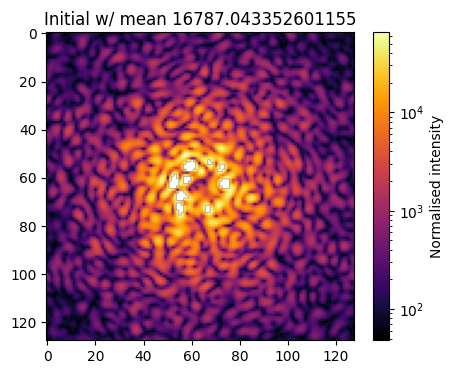

Iter 00 | ⟨I⟩_DH = 9.225e+03


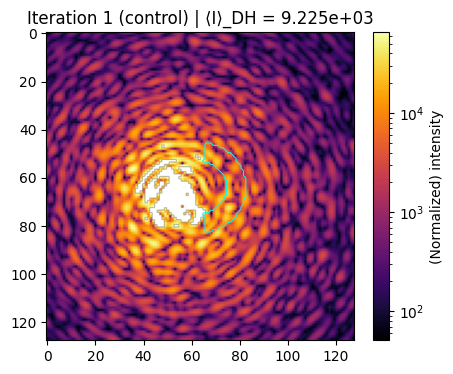

Iter 01 | ⟨I⟩_DH = 5.666e+03


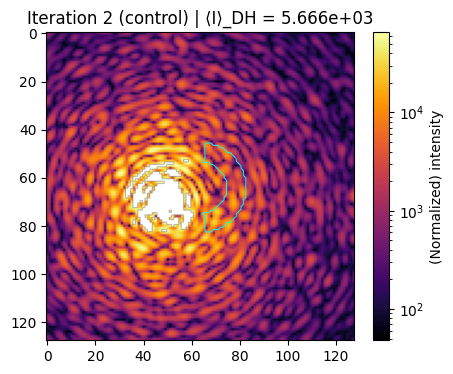

Iter 02 | ⟨I⟩_DH = 4.730e+03


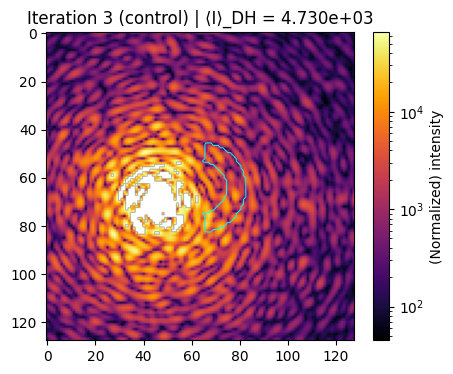

Iter 03 | ⟨I⟩_DH = 3.722e+03


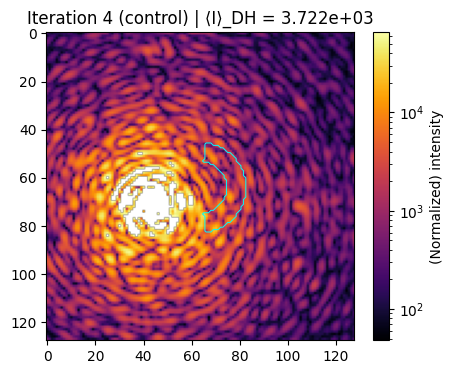

Iter 04 | ⟨I⟩_DH = 3.490e+03


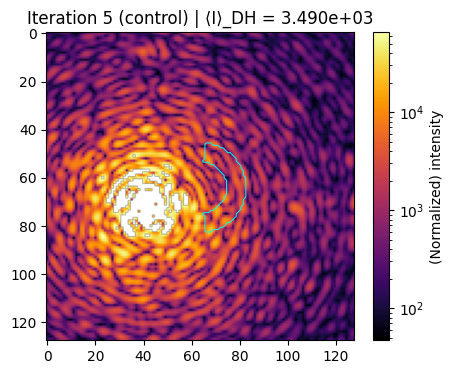

Iter 05 | ⟨I⟩_DH = 3.312e+03


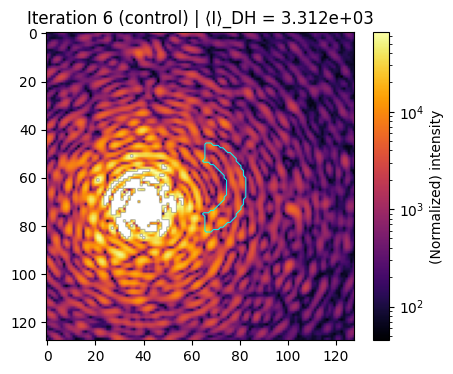

Iter 06 | ⟨I⟩_DH = 3.192e+03


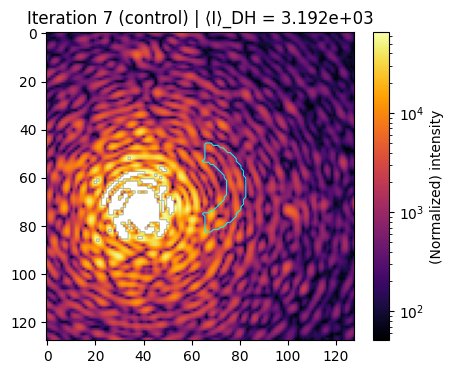

Iter 07 | ⟨I⟩_DH = 3.022e+03


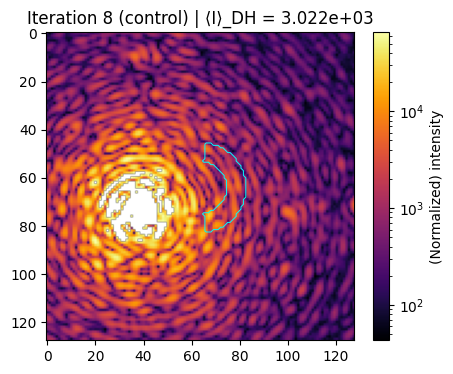

Iter 08 | ⟨I⟩_DH = 2.816e+03


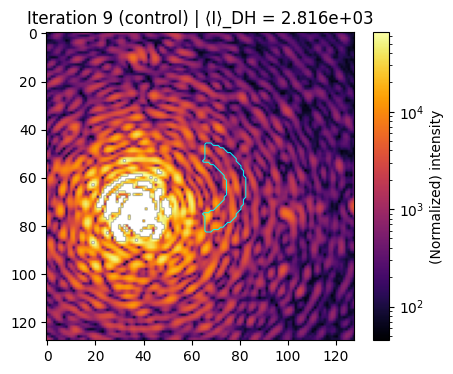

KeyboardInterrupt: 

In [48]:
# USER SETTINGS
# ------------------------------------------------------------------
nsteps        = 12          # number of Kalman iterations
apply_control = True        # send DM correction u each step
show_plots    = True        # display DH image every iteration
# ------------------------------------------------------------------


# Build telescope, DM
keck, dm, wfe_offset, Nd, NR = build_sim_env()     

global ref
# ref = keck.get_coronagraph_image(include_fpm=False).max()
ref = 1

# SAN helper
san = SpeckleAreaNulling(
    propagation=keck.get_coronagraph_image,
    dx_img=keck.dx_img,
    epd=keck.epd, efl=keck.efl, wvl=keck.center_wavelength,
    dm=dm,
    IWA=4, OWA=7,
    angular_range=[-85, 85],
)
'''plt.figure(figsize=(5, 4))
plt.title("Dark Hole")
plt.contour(san.dh, levels=[0.5], colors='black', linewidths=0.7)
plt.show()'''

# Kalman filter
mask = san.dh.astype(bool)
kf = SANKalman(mask=mask,
               gain=keck.conversion_gain,
               q_process=1e-6)


# Function to get one 5-frame burst
def acquire_burst(sys, san_obj, dm, wfe_offset):
    images = []
    I0 = sys.get_coronagraph_image(include_fpm=True, wfe=dm.render(wfe=True)) / ref
    images.append(I0)


    for probe in (-san_obj.sin_probe, san_obj.sin_probe,
                  -san_obj.cos_probe, san_obj.cos_probe):
        dm.actuators[:] += probe

        I = sys.get_coronagraph_image(include_fpm=True,
                                      wfe=dm.render(wfe=True) ) / ref
        
        dm.actuators -= probe
        images.append(I)

    I1m, I1p, I2m, I2p = images[1:]
    return I0, I1p, I1m, I2p, I2m


def snr_image_ccd(I_adu, G, Ns_e=0.0, Nd_e=0.0, Nr_e=0.0):
    """
    Per-pixel SNR for an image in ADU using the CCD equation.
    Ns_e, Nd_e, Nr_e are electrons/pixel accumulated over the exposure.
    """
    var_adu = (I_adu / G) + (Ns_e + Nd_e + Nr_e**2) / (G**2)
    sigma   = np.sqrt(np.clip(var_adu, 0, None))
    return np.divide(I_adu, sigma, out=np.zeros_like(I_adu, float), where=sigma > 0)


    
# Initialize P0, R with first burst
I0, I1p, I1m, I2p, I2m = acquire_burst(keck, san, dm, wfe_offset)
kf.initialize(I0, I1p, I1m, I2p, I2m, rigorous=True,
                   Ns=0, Nd=Nd, Nr=NR)

plt.figure(figsize=(5, 4))
mean0 = np.mean(I0[mask])
plt.title("Initial w/ mean " + str(mean0))
plt.imshow(I0, cmap='inferno', norm=LogNorm())
plt.colorbar(label='Normalised intensity')
plt.show()


# Kalman-SAN
means = []
res_p, res_q   = [], []   
sig_p, sig_q   = [], []    # 3-sigma bounds

for k in range(nsteps):
    u_signal = np.zeros_like(dm.actuators)
    if np.allclose(u_signal, 0):          # no control stroke this step
        kf.predict(control=False)
    else:                                 # stroke was applied
        kf.predict(control=True)

    I0, I1p, I1m, I2p, I2m = acquire_burst(keck, san, dm, wfe_offset)
    kf.update(I0, I1p, I1m, I2p, I2m)

    y0, y1 = kf.last_innovation           
    res_p.append(np.mean(y0))
    res_q.append(np.mean(y1))
    # 3-sigma = 3·sqrt(diag P⁺)   (posterior already computed)
    sig_p.append(3 * np.sqrt(np.mean(kf.P[:, 0, 0])))
    sig_q.append(3 * np.sqrt(np.mean(kf.P[:, 1, 1])))                       


    # control
    if apply_control:
        sin_c = -kf.x[0][:, None, None]
        cos_c = -kf.x[1][:, None, None]
        dm.actuators[:] += (sin_c * san.sin_modes + cos_c * san.cos_modes).sum(axis=0)

        u_signal = (sin_c * san.sin_modes + cos_c * san.cos_modes).sum(axis=0)

        '''max_iter = 5
        tol = 1e-4
        for j in range(max_iter):
            x_prev = kf.x.copy()
            kf.predict(control=None)                     # no further DM move
            I0, I1p, I1m, I2p, I2m = acquire_burst(keck, san, dm, wfe_offset)
            kf.update(I0, I1p, I1m, I2p, I2m)
            if np.linalg.norm(kf.x - x_prev) / np.sqrt(kf.npix) < tol:
                break'''

    else:
        u_signal = np.zeros_like(dm.actuators)

    # diagnostics
    img = keck.get_coronagraph_image(include_fpm=True,
                                     wfe=dm.render(wfe=True)) / ref
    means.append(np.mean(img[mask]))
    print(f"Iter {k:02d} | ⟨I⟩_DH = {means[-1]:.3e}")
    
    
    if show_plots:
        plt.figure(figsize=(5, 4))
        plt.title(f"Iteration {k+1} ({'control' if apply_control else 'open'}) | ⟨I⟩_DH = {means[-1]:.3e}")
        plt.imshow(img, cmap='inferno', norm=LogNorm())
        plt.colorbar(label='(Normalized) intensity')
        plt.contour(mask, levels=[0.5], colors='cyan', linewidths=0.7)
        plt.show()
        
        '''N_s = 0.0                                   # electrons/pix from sky (if any)
        N_d = keck.dark_current * keck.exposure_time
        N_r = keck.read_noise

        snr_img = snr_image_ccd(img, keck.conversion_gain, Ns_e=N_s, Nd_e=N_d, Nr_e=N_r)

        plt.figure(figsize=(5,4))
        plt.title("Per-pixel SNR (CCD equation)")
        plt.imshow(snr_img, cmap='magma')
        plt.colorbar(label='SNR')
        # draw DH outline if you like
        plt.contour(san.dh, levels=[0.5], colors='w', linewidths=0.8)
        plt.show()'''


        
# Convergence plot
plt.figure()
plt.semilogy(means, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Mean DH (normalized) intensity")
plt.title("Kalman-SAN convergence")
plt.grid(True)
plt.show()

In [15]:
# gating


Iter 00 | ⟨I⟩_DH = 3.243e+03


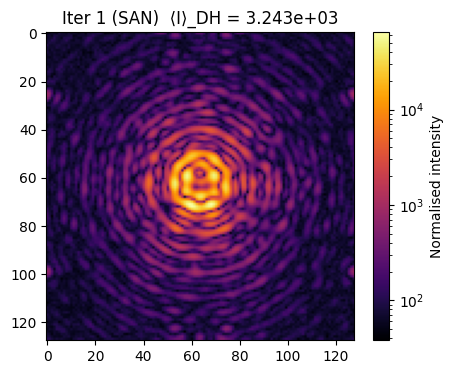

Iter 01 | ⟨I⟩_DH = 3.834e+03


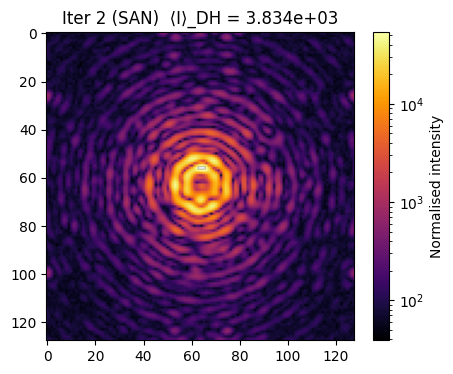

Iter 02 | ⟨I⟩_DH = 6.234e+01


Iter 03 | ⟨I⟩_DH = 9.030e+01


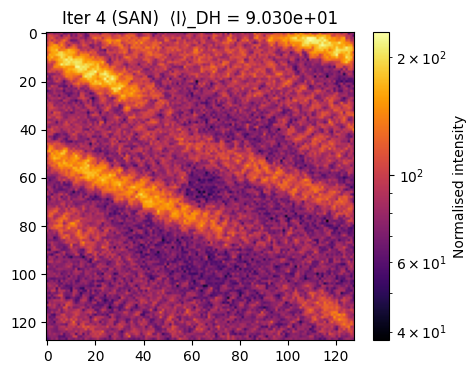

Iter 04 | ⟨I⟩_DH = 1.272e+02


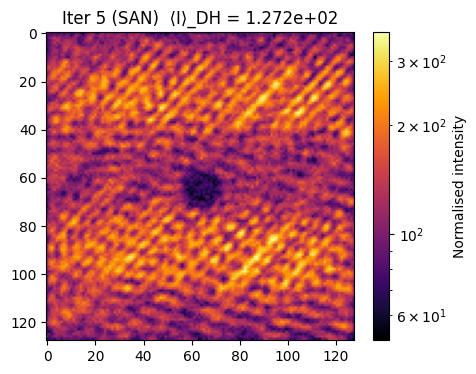

Iter 05 | ⟨I⟩_DH = 1.008e+02


Iter 06 | ⟨I⟩_DH = 1.294e+02


Iter 07 | ⟨I⟩_DH = 1.110e+02


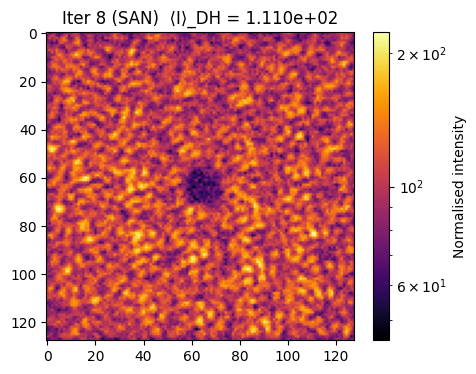

Iter 08 | ⟨I⟩_DH = 1.332e+02


Iter 09 | ⟨I⟩_DH = 9.745e+01


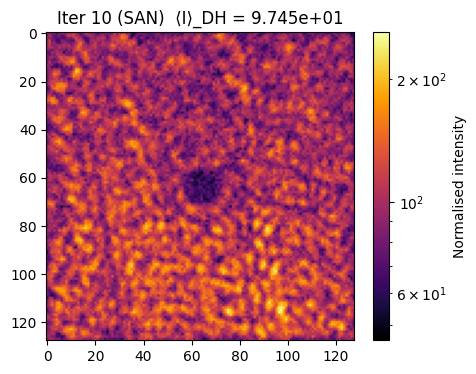

In [27]:
# SAN regularization for comparison

nsteps        = 10
apply_control = True
show_plots    = True
regularization = 1e-5         

keck, dm, wfe_offset, Nd, NR = build_sim_env()     

# SAN helper
san = SpeckleAreaNulling(
    propagation=keck.get_coronagraph_image,
    dx_img=keck.dx_img,
    epd=keck.epd, efl=keck.efl, wvl=keck.center_wavelength,
    dm=dm,
    IWA=4, OWA=7,
    angular_range=[-85, 85],
)

means = []
for k in range(nsteps):

    # 5-frame burst
    I0, I1p, I1m, I2p, I2m = acquire_burst(keck, san, dm, wfe_offset)

    dE1   = (I1p - I1m) / 4
    dE2   = (I2p - I2m) / 4
    dE1sq = (I1p + I1m - 2*I0) / 2
    dE2sq = (I2p + I2m - 2*I0) / 2

    sin_coeffs = dE1 / (dE1sq + regularization)
    cos_coeffs = dE2 / (dE2sq + regularization)

    # restrict to dark hole
    dh_mask = san.dh.astype(bool) 
    sin_c = (-sin_coeffs[dh_mask]).reshape(-1, 1, 1) 
    cos_c = (-cos_coeffs[dh_mask]).reshape(-1, 1, 1)

    if apply_control:
        stroke = (sin_c * san.sin_modes + cos_c * san.cos_modes).sum(axis=0)
        dm.actuators += stroke

    # diagnostics
    img = keck.get_coronagraph_image(include_fpm=True,
                                     wfe=dm.render(wfe=True)) / ref
    means.append(np.mean(img[dh_mask]))
    print(f"Iter {k:02d} | ⟨I⟩_DH = {means[-1]:.3e}")

    if show_plots:
        plt.figure(figsize=(5,4))
        plt.title(f"Iter {k+1} (SAN)  ⟨I⟩_DH = {means[-1]:.3e}")
        plt.imshow(img, cmap='inferno', norm=LogNorm())
        plt.colorbar(label='Normalised intensity')
        plt.show()


# Convergence curve
plt.figure()
plt.semilogy(means, marker='o')
plt.xlabel('Iteration'); plt.ylabel('Mean DH intensity')
plt.title('Classical SAN convergence'); plt.grid(True); plt.show()
